# Atomic type spectroscopy (Haroche, pg. 853), <mark>without thermal losses</mark> 

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Probing qubit 1 with to a laser field** (No thermal losses considered)
    * Function generators
    * Plotting the pertubation
    * Plotting the results of the pertubation on the system
5. **Results**
    * Final state, Fidelity, Concurrence

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 16th July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A probe laser fiels targets an atom (qubit 1) in an optical mutimode 3 cavity QED experiment. The probe field can be decribed as $E_p\ e^{-i\nu t}$
The code calculates the effect of such a pertubation on the system by demonstrating how the occupation probability of qubit 1 changes with time. It also shows how the pertubation afftects the rest of the components in the system.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 16})

import numpy as np
import cmath
from math import pi

from time import sleep
import sys

from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [3]:
"""------------- FREQUENCIES --------------------"""
w_q1 = 2*pi*6.4;    # Qubit 1 frequency
w_q2 = 2*pi*6.8;    # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1      # Resonator/ Filter frequency

# from notebook on 3 cavities we saw that cavity splits into 3 levels
w_f1 = 2*pi*6.933
w_f2 = 2*pi*7.1
w_f3 = 2*pi*7.2668
"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.0118    # Filter-filter coupling
g_f2 = 2*pi*0.0344 
g_q1f = 2*pi*0.0135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.0415   # qubit 2-fitler coupling

numF = 3            # number of filters
N = 2               # number of fock states 

times = np.linspace(0,100,500)
nu_list = np.linspace(0.0, 5.0, 20)
width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g_q1f)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g_q2f)                                           

## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [4]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m2.dag()*m1

### 3.1 Operators 

In [6]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

# collapse operators
c_ops = []

### 3.2 Hamiltonian's and initial state

In [7]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = 0.5*sz1       
Hq2 = 0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# time-independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf
 
H = H0 + w_q1*Hq1 + w_q2*Hq2  # Resultant Hamiltonian

### 3.3 Initial State

In [8]:
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,0), basis(2,1))

## 4. Probing qubit 1 with to a laser field

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 - f_1(t)H_1 - f_2(t)H_2$$
where $H_0$ is called the time-independent drift Hamiltonian, $\ H_1 = \sigma_1^+$, and $\ H_2 = \sigma_1^-$ are the control Hamiltonians with a time varying amplitude $f_1(t) = \Omega_pe^{-i\nu t}$ and $f_2(t) = \Omega_pe^{i\nu t}$.

Here we write the Hamiltonian in a function-based time dependent way. See other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). Here the time-dependent coefficients, $f_n(t)$ of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Function generators

In [14]:
def H1_coeff(t, args):
    W_p = args['Omega1']
    nu = args['nu'] 
    z = complex(0,-t*nu + pi/2)
    return w_q1 - W_p*(cmath.exp(z))

def H2_coeff(t, args):
    W_p = args['Omega2']
    nu = args['nu']
    z = complex(0,t*nu + pi/2)
    return w_q1 - W_p*(cmath.exp(z))

def wf_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_f
  
def w1_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_q1 
def w2_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_q2

def wf1_t(t, args=None):
    return w_f1
def wf2_t(t, args=None):
    return w_f2
def wf3_t(t, args=None):
    return w_f3

def plotFrequencies(ax, times, wf_t, Colour, labels_, linestyle_):
    """
    Function plots the frequencies as a function of times
    """
    ax.plot(times, np.array(list(map(wf_t, times)))/(2*pi), Colour, linewidth=2, label=labels_, linestyle=linestyle_)
    
    #ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 
    
def setLabels(ax, tr, th, plot_no):
    """
    Function sets the labels of the x-y axis in the plot below
    """
    if plot_no == 0:
        ax.set_ylabel("Frequency (GHz)", fontsize=16)
        ax.set_title(labelTimes(tr, th))
    else:
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Occupation \n probability")
    return 

def plotProb(ax, times, component, res, Colour, labels_, linestyle_):
    """
    Function plots the occupation probabilities of the components after running mesolve
    """
    ax.plot(times, np.real(expect(component, res.states)), Colour, linewidth=1.5, label=labels_, linestyle=linestyle_)
    
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 

def setXYlabel(ax, x, y, req_title, title_):
    """
    Generic function to set labels for plots
    """
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if req_title == True:
        ax.set_title(title_)
    return 

def plotSineWaves(ax, H1_coeff, H2_coeff, times):    
    ax.plot(times, [H1_coeff(t, args=args)/(2*pi)for t in times], 'r', linewidth=2, label=r"$- \Omega_pe^{-i\nu t}$" )
    ax.plot(times, [H2_coeff(t, args=args)/(2*pi) for t in times], 'b:', linewidth=2, label=r"$- \Omega_pe^{+i\nu t}$")
    ax.plot(times, [(H1_coeff(t, args=args)+H2_coeff(t, args=args) -w_q1)/(2*pi) for t in times], 'g', label=r"$- \Omega_pe^{-i\nu t}- \Omega_pe^{+i\nu t}$")
    ax.legend(loc="upper right")
    setXYlabel(ax, 'Time (ns)', 'Frequency (GHz)', True, r'Perturbating Qubit 1: $- f_1(t)H_1 - f_2(t)H_2$ ')
    return

In [50]:
# time dependent Hamiltonian
args = {'Omega1': 0.75*(w_f-w_q1), 'nu': 0.2, 'Omega2': 0.75*(w_f-w_q1)}
H_t = [H, [sm1.dag(), H1_coeff], [sm1, H2_coeff]]

# Evolving the system
output = mesolve(H_t, psi0, times, c_ops, [], args=args)

### 4.2 Plotting the pertubation

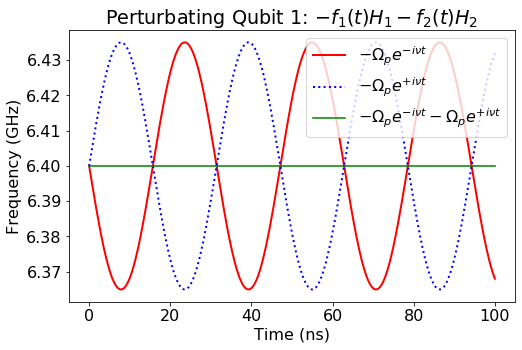

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
plotSineWaves(ax, H1_coeff, H2_coeff, times)

### 4.3 Plotting the results (No thermal losses)

For different combinations of qubit and cavity. 

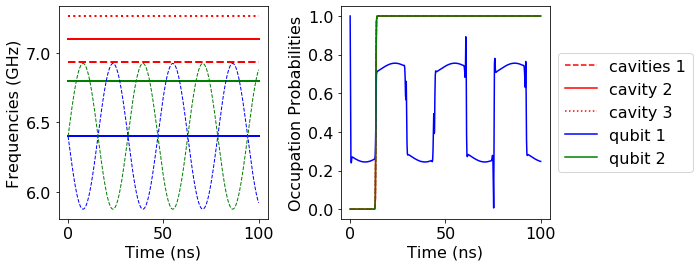

In [51]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

labels_ = ["cavities 1", "cavity 2", "cavity 3", "qubit 1", "qubit 2"]
w_list = [wf1_t, wf2_t, wf3_t, w1_t, w2_t]
colors_ = ['r', 'r', 'r', 'b', 'g']
linestyle_ = ['--', '-', ':', '-', '-']
components_ = [numOp(a1), numOp(a2), numOp(a3), n1, n2]

for i in [0, 1, 2, 3, 4]:
    plotFrequencies(axes[0], times, w_list[i], colors_[i], labels_[i], linestyle_[i])
axes[0].plot(times, [H1_coeff(t, args=args)/(2*pi)for t in times], 'b--', linewidth=1., label=r"$- \Omega_pe^{-i\nu t}$" )
axes[0].plot(times, [H2_coeff(t, args=args)/(2*pi) for t in times], 'g--', linewidth=1., label=r"$- \Omega_pe^{+i\nu t}$")    
setXYlabel(axes[0], 'Time (ns)', 'Frequencies (GHz)', False, ' ')

for i in [0, 1, 2, 3, 4]:
    plotProb(axes[1], times, components_[i], output, colors_[i], labels_[i], linestyle_[i])
setXYlabel(axes[1], 'Time (ns)', 'Occupation Probabilities', False, ' ')

fig.tight_layout()

## 5. Scanning parameter space of the peturbing frequency

In [105]:
def showProgress(idx, n):
    """
    Function prints the progress bar for a running function
    @param idx :: iterating index
    @param n :: total number of iterating variables/ total length
    """
    j = (idx+1)/n
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.25)

def probe(nulist, w_p):
    """
    Calculating the expectation values of qubit 1 for a range of 'nu' values
    @param nu_list :: np array containing the 'nu' values
    
    @returns expect_vals :: 2d np array containing the list of expectation values for every nu
    """
    expect_vals = np.empty((0, len(times)))
    for i, nu in enumerate(nulist):
        args = {'Omega1': w_p, 'nu': nu, 'Omega2': w_p-1} 
        H_t = [H, [sm1.dag(), H1_coeff], [sm1, H2_coeff]]
        
        # Evolving the system
        output = mesolve(H_t, psi0, times, c_ops, [n1], args=args)
        expect_list = output.expect[0]
        
        # progress bar
        showProgress(i, len(nulist))
        
        expect_vals  = np.append(expect_vals, [expect_list], axis=0)
    return expect_vals

In [106]:
expect_vals = probe(nu_list, 7)
print("Dimensions of the resultant 2D array:", np.shape(expect_vals))

[====================] 100%Dimensions of the resultant 2D array: (20, 500)


### 5.1 Demonstrating the effect of pertubation using a 3D plot

Here for every $\nu$, the effect on the evolution of the expectation values of qubit 1 is demonstrated.

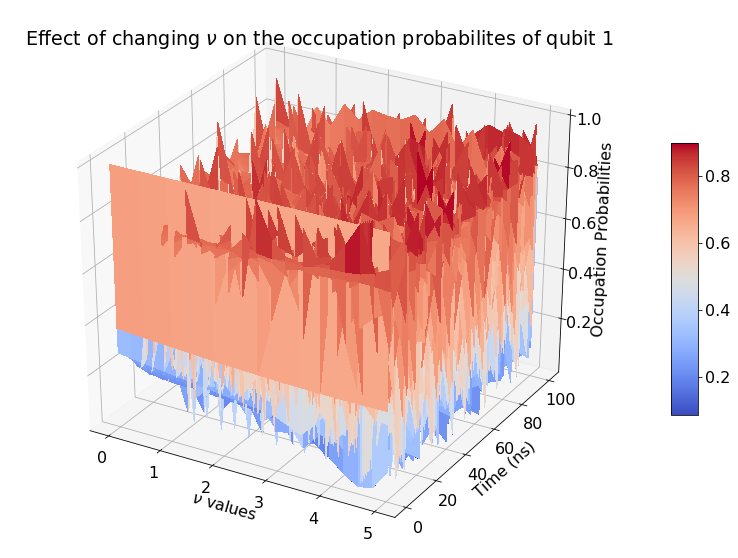

In [111]:
fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(nu_list, times)

surf = ax.plot_surface(X, Y, np.transpose(expect_vals), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

#surf2 = ax.plot_wireframe(X, Y, np.transpose(expect_vals), rstride=40, cstride=40, color='k', linewidth=0.5) 

# Add a color bar, axis properties
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel(r'$\nu$ values')
ax.set_ylabel('Time (ns)')
ax.set_zlabel('Occupation Probabilities');
ax.set_title(r'Effect of changing $\nu$ on the occupation probabilites of qubit 1')
plt.show()

Exploring slices of the above plot at different values of $\nu$ for **qubit 1**:

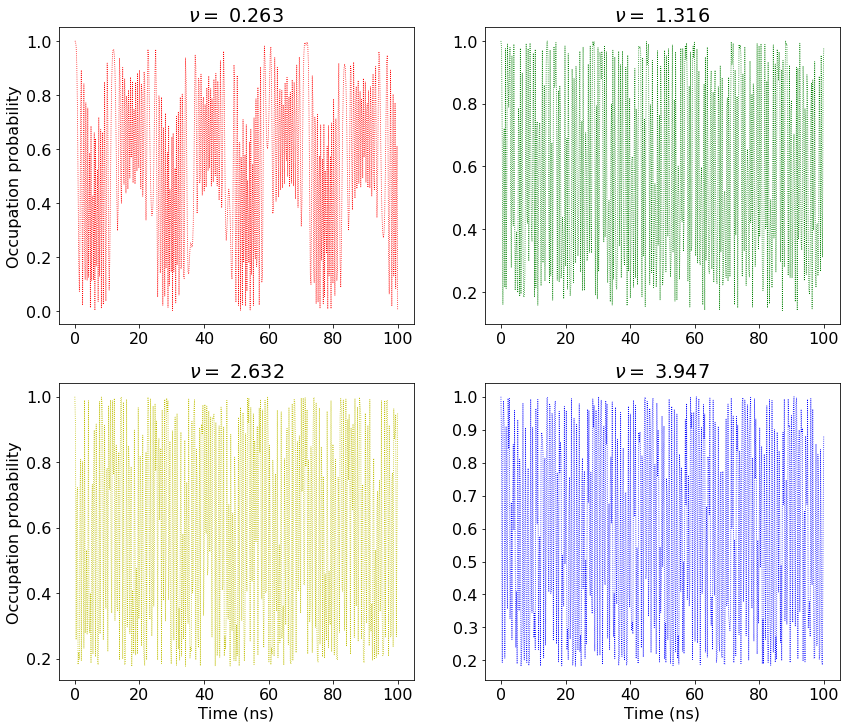

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(14,12))
# 1st plot
ax[0, 0].plot(times, expect_vals[1][:], 'r:', linewidth=0.8)
ax[0, 0].set_title(r'$\nu = $ {0:.3f}'.format(nu_list[1]));
ax[0, 0].set_ylabel('Occupation probability');

# 2nd plot
ax[0, 1].plot(times, expect_vals[5][:], 'g:', linewidth=0.8)
ax[0, 1].set_title(r'$\nu = $ {0:.3f}'.format(nu_list[5]));

# 3rd plot
ax[1, 0].plot(times, expect_vals[10][:], 'y:', linewidth=0.8)
ax[1, 0].set_xlabel('Time (ns)');
ax[1, 0].set_ylabel('Occupation probability');
ax[1, 0].set_title(r'$\nu = $ {0:.3f}'.format(nu_list[10]));

# 4th plot
ax[1,1].plot(times, expect_vals[15][:], 'b:', linewidth=0.8)
ax[1,1].set_xlabel('Time (ns)')
ax[1,1].set_title(r'$\nu = $ {0:.3f}'.format(nu_list[15]));